In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
sys.path.append("./src")
import torch.optim as opt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import model
import loss_function as loss_func
from loss_function import CircleLoss, grouplasso
import utils
import new_models
import anndata as ad
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        # is the tile necessary?
        
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        # make sure the input time point are integer
        self.time_point = torch.LongTensor(time_point)
        self.batch_id = torch.Tensor(batch_id)
    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx],  "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample

In [3]:
dir = r'./data/covid/processed_covid_sample/'
batch_info = pd.read_csv(dir + 'batch_info.csv', index_col = 0)
merge_meta = pd.read_csv(r'./data/covid/merge_meta.csv', index_col = 0)
pd.set_option('display.max_rows', None)

/nethome/xzhao429/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
merge_meta.head()

,sampleID,celltype,majorType,batch_id,severity,Sample time,Sampling day,City,Age,Sex
cellName,,,,,,,,,,
AACAGGGGTCGGATTT-0,S-S070-1,Mono_c1-CD14-CCL3,Mono,Batch01,severe/critical,progression,7,Zhuhai,32,F
AACCAACGTCCGAAAG-0,S-S070-1,B_c02-MS4A1-CD27,B,Batch01,severe/critical,progression,7,Zhuhai,32,F
AACCTTTGTAGCACGA-0,S-S070-1,B_c01-TCL1A,B,Batch01,severe/critical,progression,7,Zhuhai,32,F
AAGCATCTCTATCGCC-0,S-S070-1,Mono_c2-CD14-HLA-DPB1,Mono,Batch01,severe/critical,progression,7,Zhuhai,32,F
AATCACGGTCATAAAG-0,S-S070-1,B_c01-TCL1A,B,Batch01,severe/critical,progression,7,Zhuhai,32,F


In [5]:
female = [i.split('-')[-1] for i in merge_meta[(merge_meta['Sex'] == 'F') ].index.tolist()]
female = list(set(female))
female= [int(i) for i in female]
female.sort()

male = [i.split('-')[-1] for i in merge_meta[(merge_meta['Sex'] == 'M') ].index.tolist()]
male = list(set(male))
male= [int(i) for i in male]
male.sort()
print('F', np.array(female))
print('M', np.array(male))

F [  0   1   2   3   4   5  13  16  19  20  23  25  29  37  38  39  43  44
  46  49  51  54  55  56  57  58  63  64  65  66  73  74  75  76  77  78
  90  91  96 101 102 109 111 115 116 117 120 121 123 126 127 136 140 141
 142 143 144 145 146 147 156 157 158 159 170 171 172 173 174 175 176 177
 178 179 185 190 191 193 194 195 198 199 201 203 204 205 213 215 216 219
 223 230 236 239 240 241 248 255 265 266 268 271 273 275 282 283]
M [  6   7   8   9  10  11  12  14  15  17  18  21  22  24  26  27  28  30
  31  32  33  34  35  36  40  41  42  45  47  48  50  52  53  59  60  61
  62  67  68  69  70  71  72  79  80  81  82  83  84  85  86  87  88  89
  92  93  94  95  97  98  99 100 103 104 105 106 107 108 110 112 113 114
 118 119 122 124 125 128 129 130 131 132 133 134 135 137 138 139 148 149
 150 151 152 153 154 155 160 161 162 163 164 165 166 167 168 169 180 181
 182 183 184 186 187 188 189 192 196 197 200 202 207 208 209 210 211 212
 214 217 218 220 221 222 224 225 226 227 228 229 231 2

## Print smaple id for different severity and sample time

In [6]:
sv = ['severe/critical', 'mild/moderate']
st = ['progression', 'convalescence']
severity_dict = {}
for i in st:
    for j in sv:
        convalescence = [i.split('-')[-1] for i in merge_meta[(merge_meta['Sample time'] == i) & (merge_meta['severity'] == j)].index.tolist()]
        convalescence = list(set(convalescence))
        convalescence= [int(i) for i in convalescence]
        convalescence.sort()
        print(i, j, np.array(convalescence))
        severity_dict[i+' '+j] = np.array(convalescence)
        print('         ')

progression severe/critical [  0   1   2   3   4   5   6   7   8   9  10  18  19  25  26  45  46  49
  69  70  71  72  77  78  79  80  83  84  87  97  99 100 101 102 103 105
 106 109 110 111 112 113 137 139 222 223 224 225 226 227 228 229 232 233
 234 235 236 237 238 239 240 241 242 243 246 247 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283]
         
progression mild/moderate [ 11  12  13  17  20  21  22  23  24  92  93  94  95  96  98 107 108 114
 115 116 136 140 142 143 144 148 149 150 230 231 244 245 248]
         
convalescence severe/critical [ 37  38  40  43  44  47  50  51  85  86  88  89 104 119 120 125 126 127
 128 130 138 160 161 162 163 164 165 166 167 168 169 182 183 184 185 186
 187 188 189 191 192 194 200 259 260 261 262 263 264 265 266]
         
convalescence mild/moderate [ 14  15  16  27  28  29  35  36  39  41  42  48  57  58  59  60  63  64
  65  66  73  74  75  76  90  91 121 122 123 124 129 133 134 135 141 145
 146 147 151 152 153 154 155 15

## Print sample id for BALF and SPUTUM source

In [7]:
balf_lst = ['S-M074-1','S-M075','S-S086-1','S-M076-1','S-S085-1','S-S087-1','S-S088-1','S-S089-1','S-S090-1','S-S006','S-S008','S-S009']
sputum_lst = ['S-S010-1','S-S011-1','S-S012-1','S-M002-1','S-M003-1','S-S010-2','S-S005-1','S-S001-1','S-S007-1','S-S007-2','S-M003-2','S-M003-3','S-S005-2','S-S011-2','S-M002-2','S-S012-2','S-S002','S-S003','S-S012-3','S-S004-1','S-S004-2','S-S004-3',]
balf_np = np.array(list(set([int(i.split('-')[-1]) for i in merge_meta[(merge_meta['sampleID'].isin(balf_lst))].index.tolist()])))
sputum_np = np.array(list(set([int(i.split('-')[-1]) for i in merge_meta[(merge_meta['sampleID'].isin(sputum_lst))].index.tolist()])))
print('BALF',balf_np)
print('sputum',sputum_np)

BALF [ 96  97  98  99 100 101 102 103 223 224 222  95]
sputum [227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248]


In [8]:
balf_f = np.intersect1d(balf_np, female)
balf_m = np.intersect1d(balf_np, male)
sputum_f = np.intersect1d(sputum_np, female)
sputum_m = np.intersect1d(sputum_np, male)
del_lst = np.union1d(np.union1d(np.union1d(balf_f, balf_m), sputum_f), sputum_m)
print('balf & F', balf_f)
print('balf & M',balf_m)
print('sputum & F', sputum_f)
print('sputum & M',sputum_m)
for name, lst in severity_dict.items():
#     print(name, 'F', np.intersect1d(female, lst))
#     print(name, 'M', np.intersect1d(male, lst))     
    print(name, 'F', np.setdiff1d(np.intersect1d(female, lst), del_lst))
    print(name, 'M', np.setdiff1d(np.intersect1d(male, lst), del_lst))
    print('     ')


balf & F [ 96 101 102 223]
balf & M [ 95  97  98  99 100 103 222 224]
sputum & F [230 236 239 240 241 248]
sputum & M [227 228 229 231 232 233 234 235 237 238 242 243 244 245 246 247]
progression severe/critical F [  0   1   2   3   4   5  19  25  46  49  77  78 109 111 268 271 273 275
 282 283]
progression severe/critical M [  6   7   8   9  10  18  26  45  69  70  71  72  79  80  83  84  87 105
 106 110 112 113 137 139 225 226 267 269 270 272 274 276 277 278 279 280
 281]
     
progression mild/moderate F [ 13  20  23 115 116 136 140 142 143 144]
progression mild/moderate M [ 11  12  17  21  22  24  92  93  94 107 108 114 148 149 150]
     
convalescence severe/critical F [ 37  38  43  44  51 120 126 127 185 191 194 265 266]
convalescence severe/critical M [ 40  47  50  85  86  88  89 104 119 125 128 130 138 160 161 162 163 164
 165 166 167 168 169 182 183 184 186 187 188 189 192 200 259 260 261 262
 263 264]
     
convalescence mild/moderate F [ 16  29  39  57  58  63  64  65  66  7

In [9]:
batch_info

,critical,moderate,control
sample0,"(239, 2000)",NaN,NaN
sample1,"(2944, 2000)",NaN,NaN
sample2,"(2101, 2000)",NaN,NaN
sample3,"(637, 2000)",NaN,NaN
sample4,"(155, 2000)",NaN,NaN
sample5,"(5328, 2000)",NaN,NaN
sample6,"(425, 2000)",NaN,NaN
sample7,"(949, 2000)",NaN,NaN
sample8,"(57, 2000)",NaN,NaN
sample9,"(309, 2000)",NaN,NaN


In [121]:
path = r'./data/covid/processed_covid_sample/'
# n_batches = 9
counts_rnas = []
labels = []
timepoints = []
batches = []
datasets = []
str_annos = []
str_batches = []
str_tp = []
batch_dict = {'critical':[[1, 49, 86, 89], 2],
              'moderate':[[63, 76, 96, 153], 1],
              'control':[[61, 62, 67, 81], 0]
}
batch_dict_only_prog = {'critical':[[1, 2, 80], 2],
              'moderate':[[11, 23, 230], 1],
#               'moderate':[[94, 95, 96], 1], 
#                         95 and 96 are BALF
#               'control':[[61, 62, 67, 81], 0]
}

batch_dict_only_conva = {'critical':[[50, 51, 89], 2],
              'moderate':[[75, 76, 151], 1],
#               'control':[[61, 62, 67, 81], 0]
}
batch_dict_conva_ctrl = {'critical':[[50, 51, 89], 2],
              'moderate':[[75, 76, 151], 1],
              'control':[[62, 67, 30], 0]
}
batch_dict_prog_ctrl = {'critical':[[1, 2, 80], 2],
#               'moderate':[[11, 23, 230], 1],
              'moderate':[[11, 23], 1],
              'control':[[62, 67, 30], 0]
}
batch_dict_cmb = {'critical':[[50, 51, 1, 2], 2],
              'moderate':[[75, 76, 11, 23], 1],
#               'control':[[61, 62, 67, 81], 0]
}
batch_only_balf = {
#     'critical':[[101, 102], 2],
                   'critical':[[1, 2], 2],
#                    'moderate':[[95, 96], 1],
                   'moderate':[[11, 96], 1],
}

batch_sex_prog_cri = {
                   'F':[[1, 2], 1],
                   'M':[[263, 89], 2],
}
batch_sex_con_cri = {
                   'F':[[51, 126], 1],
                   'M':[[40, 50], 2],
}
batch_sex_con_mod = {
                   'F':[[58, 74], 1],
                   'M':[[60, 133], 2],
}
batch_sex_comb = {
                   'F-moderate':[[58, 74], 1],
                   'F-critical':[[51, 126], 1],
                   'M-moderate':[[60, 133], 2],
                   'M-critical':[[40, 50], 2],
}
batch_sex_comb_pro_con = {
                   'F-conv-moderate':[[58, 74], 1],
                   'F-prog-critical':[[1, 2], 1],
                   'M-conv-moderate':[[60, 133], 2],
                   'M-prog-critical':[[263, 89], 2],
}

n = 0
for severity, label in batch_sex_comb_pro_con.items():
    idxes = label[0]
    time_point = label[1]
    plt_name = severity
    severity = severity[7:]
    for idx in idxes:
        #################

        #################
        counts_rnas.append(np.array(sparse.load_npz(os.path.join(dir, '{}/mtx_batch_{}_{}.npz'.format(severity,idx,severity))).todense()))
        str_annos.append((pd.read_csv(os.path.join(dir, '{}/meta_batch_{}_{}.csv'.format(severity,idx,severity)))["majorType"]))
        labels.append(le.fit_transform(pd.read_csv(os.path.join(dir, '{}/meta_batch_{}_{}.csv'.format(severity,idx,severity)))["majorType"]))
        str_tp.append(['sex '+str(time_point)+'-'+plt_name[:1]] * counts_rnas[-1].shape[0])
        timepoints.append([time_point] * counts_rnas[-1].shape[0])
        str_batches.append(['batch '+str(n)+'-'+plt_name]* counts_rnas[-1].shape[0])
        batches.append([n] * counts_rnas[-1].shape[0])
        datasets.append(dataset(counts = counts_rnas[-1],anno = labels[-1], time_point = [time_point] * counts_rnas[-1].shape[0], 
                         batch_id = [n] * counts_rnas[-1].shape[0]))
        print(severity, idx, 'finished', time_point)
        n += 1
    
n_batches = len(datasets)

moderate 58 finished 1
moderate 74 finished 1
critical 1 finished 1
critical 2 finished 1
moderate 60 finished 2
moderate 133 finished 2
critical 263 finished 2
critical 89 finished 2


In [105]:
class new_ae(nn.Module):
    """\
    Description:
    --------------
        New model that separate the encoder and control backward gradient. (AUTOENCODER)

    """
    def __init__(self, datasets, Ks = [16, 8], batch_size = 64, interval = 10, lr = 5e-4, lambs = [1,1,1], seed = 0, device = device, contr_loss = None):
        super().__init__()
        # initialize the parameters
        self.datasets = datasets
        self.Ks = {"common_factor": Ks[0], 
                   "time_factor": Ks[1]}

        self.batch_size = batch_size
        self.interval = interval
        self.lr = lr
        self.lambs = lambs
        self.seed = seed 
        self.device = device
        self.contr = contr_loss

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # create data loaders
        self.train_loaders = []
        # store the number of cells for each batch
        self.ncells = []
        # store the number of time points
        self.time_points = []
        for batch_id, dataset in enumerate(self.datasets):
            self.train_loaders.append(DataLoader(dataset, batch_size = self.batch_size, shuffle = True))

            self.ncells.append(dataset.counts.shape[0])

            # make sure that the genes are matched
            if batch_id == 0:
                self.ngenes = dataset.counts.shape[1]
            else:
                assert self.ngenes == dataset.counts.shape[1]
            # make sure that each dataset has one unique time point
            time_point = torch.unique(dataset.time_point)
            assert time_point.shape[0] == 1
            self.time_points.append(time_point)

        # create model
        # encoder for common biological factor
        self.Enc_c = model.Encoder(features = [self.ngenes, 256, 64, self.Ks["common_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # encoder for time factor
        self.Enc_t = model.Encoder(features = [self.ngenes, 256, 64, self.Ks["time_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: reconstruct the original data, use all latent dimensions as input
        self.Dec = model.Decoder(features = [self.Ks["common_factor"] + self.Ks["time_factor"], 64, 256, self.ngenes], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: classify the time point, out dim = number of unique time points, currently use only time dimensions as input, update the last layer to be linear
        # self.classifier = model.classifier(features = [self.Ks["time_factor"], 4, len(self.time_points)]).to(self.device)
        # use a linear classifier as stated in the paper
        self.classifier = nn.Linear(self.Ks["time_factor"], len(self.time_points)).to(self.device)

        # parameter when training the common biological factor
        self.param_common = [
            {'params': self.Enc_c.parameters()},
            {'params': self.Dec.parameters()}            
        ]

        # parameter when training the time factor
        self.param_time = [
            {'params': self.Enc_t.parameters()},
            {'params': self.classifier.parameters()}            
        ]

        # declare optimizer for time factor and common biological factor separately
        self.opt_common = opt.Adam(self.param_common, lr = self.lr)
        self.opt_time = opt.Adam(self.param_time, lr = self.lr)

    
    def train(self, nepochs = 50):
        lamb_pi = 1e-5
        ce_loss = nn.CrossEntropyLoss(reduction = 'mean')
                
        loss_tests = []
        loss_recon_tests = []
        loss_mmd_tests = []
        loss_class_tests = []
        loss_gl_tests = []

        for epoch in range(nepochs + 1):
            for data_batch in zip(*self.train_loaders):
                loss_recon = 0
                loss_class = 0
                loss_contr = 0
                loss_gl = 0
                
                zs_contr = {}
                zs_contr['time_point'] = []
                zs_contr['x'] = []
                zs_mmd = []
                # 1. train on common factor
                for batch_id, x in enumerate(data_batch):
                    z_c = self.Enc_c(x["count_stand"].to(self.device))
                    # freeze the gradient of Enc_t and classifier
                    # NOTE: use torch no_grad, set requires_grad to False alternatively
                    with torch.no_grad():
                        z_t = self.Enc_t(x["count_stand"].to(self.device))
                    z = torch.concat((z_c, z_t), dim = 1)
                    mu, pi, theta = self.Dec(z)

                    loss_recon += loss_func.ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(self.device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(self.device), y_pred = mu)
                    zs_mmd.append(z_c)
                                
                loss_mmd = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                loss = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd
                loss.backward()

                # NOTE: check the gradient of Enc_t and classifier to be None or 0
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                    for x in self.classifier.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Enc_c.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Dec.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                     

                self.opt_common.step()
                self.opt_common.zero_grad()

                # 2. train on time factor
                n = 0 
                for batch_id, x in enumerate(data_batch):
                    # freeze the gradient of Enc_c
                    with torch.no_grad():
                        z_c = self.Enc_c(x["count_stand"].to(self.device))
                    z_t = self.Enc_t(x["count_stand"].to(self.device))
                    zs_contr['x'].append(z_t)
                    zs_contr['time_point'].append(x["time_point"])
                    t_pred = self.classifier(z_t)
                    loss_gl += grouplasso(self.Enc_t.fc.fc_layers[0].linear.weight)

                    loss_class += ce_loss(input = t_pred, target = x["time_point"].to(self.device))
                # TODO: contrastive loss, note that the same data batch have cells from only one cluster, contrastive loss should be added jointly
                loss_contr = self.contr(torch.cat(zs_contr['x']), torch.cat(zs_contr['time_point']))
#                 loss = self.lambs[2] * loss_class + loss_contr * self.lambs[3]
                loss = self.lambs[2] * loss_class + loss_contr * self.lambs[3] + loss_gl * self.lambs[4]

                loss.backward()

                # NOTE: check the gradient of Enc_c and Dec to be 0 or None
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.classifier.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Enc_c.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Dec.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6

                self.opt_time.step()
                self.opt_time.zero_grad()
            
            # TEST:
            if epoch % self.interval == 0:
                loss_recon_test = 0
                loss_mmd_test = 0
                loss_class_test = 0
                loss_gl_test = 0
                
                zs_mmd = []
                with torch.no_grad():
                    for dataset in self.datasets:
                        z_c = self.Enc_c(dataset.counts_stand.to(self.device))
                        z_t = self.Enc_t(dataset.counts_stand.to(self.device))
                        z = torch.concat((z_c, z_t), dim = 1)
                        mu, pi, theta = self.Dec(z)
                        t_pred = self.classifier(z_t)
                        zs_mmd.append(z_c)
                        loss_gl_test += grouplasso(self.Enc_t.fc.fc_layers[0].linear.weight, alpha = 1e-2)
                        loss_class_test += ce_loss(input = t_pred, target = dataset.time_point.to(self.device))
                        loss_recon_test += loss_func.ZINB(pi = pi, theta = theta, scale_factor = dataset.libsizes.to(self.device), ridge_lambda = lamb_pi).loss(y_true = dataset.counts.to(self.device), y_pred = mu)
                    
                    loss_mmd_test = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
#                     loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test
                    loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test + loss_gl_test * self.lambs[4]
                    
                    print('Epoch {}, Validating Loss: {:.4f}'.format(epoch, loss_test.item()))
                    info = [
                        'loss reconstruction: {:.5f}'.format(loss_recon_test.item()),
                        'loss mmd: {:.5f}'.format(loss_mmd_test.item()),
                        'loss classification: {:.5f}'.format(loss_class_test.item()),
                        'loss group lasso: {:.5f}'.format(loss_gl_test.item()*0.1)
                    ]
                    for i in info:
                        print("\t", i)              
                    
                    loss_tests.append(loss_test.item())
                    loss_recon_tests.append(loss_recon.item())
                    loss_mmd_tests.append(loss_mmd_test.item())
                    loss_class_tests.append(loss_class_test.item())
                    loss_gl_tests.append(loss_gl_test.item())

        return loss_tests, loss_recon_tests, loss_mmd_tests, loss_class_tests, loss_gl_tests

In [117]:
# model1 = new_models.new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-2, 10], seed = 0, device = device)
m, gamma = 0.3, 0.1
lambs = [1, 0.1, 10, 0.005, 0.1]
contr_loss = CircleLoss(m = m, gamma = gamma)
Ks = [12, 4]
# contr_loss = SupervisedContrastiveLoss()
model1 = new_ae(datasets = datasets, Ks = Ks, batch_size = 128, interval = 10, 
                lr = 5e-4, lambs = lambs, seed = 0, device = device, contr_loss = contr_loss)
# model1 = new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-3, 10], seed = 0, device = device)

In [118]:
losses = model1.train(nepochs = 100)

Epoch 0, Validating Loss: 336.1999
	 loss reconstruction: 5.97000
	 loss mmd: 0.12558
	 loss classification: 13.60139
	 loss group lasso: 194.03124
Epoch 10, Validating Loss: 76.0210
	 loss reconstruction: 1.85659
	 loss mmd: 0.08535
	 loss classification: 6.03720
	 loss group lasso: 13.77124
Epoch 20, Validating Loss: 66.9847
	 loss reconstruction: 1.51963
	 loss mmd: 0.08955
	 loss classification: 4.71414
	 loss group lasso: 18.30654
Epoch 30, Validating Loss: 54.2080
	 loss reconstruction: 1.43316
	 loss mmd: 0.07794
	 loss classification: 3.27043
	 loss group lasso: 20.05689
Epoch 40, Validating Loss: 47.9764
	 loss reconstruction: 1.38917
	 loss mmd: 0.07582
	 loss classification: 1.93703
	 loss group lasso: 27.21087
Epoch 50, Validating Loss: 40.1712
	 loss reconstruction: 1.36102
	 loss mmd: 0.07402
	 loss classification: 1.10370
	 loss group lasso: 27.75530
Epoch 60, Validating Loss: 40.4523
	 loss reconstruction: 1.34242
	 loss mmd: 0.07004
	 loss classification: 0.76982
	 los

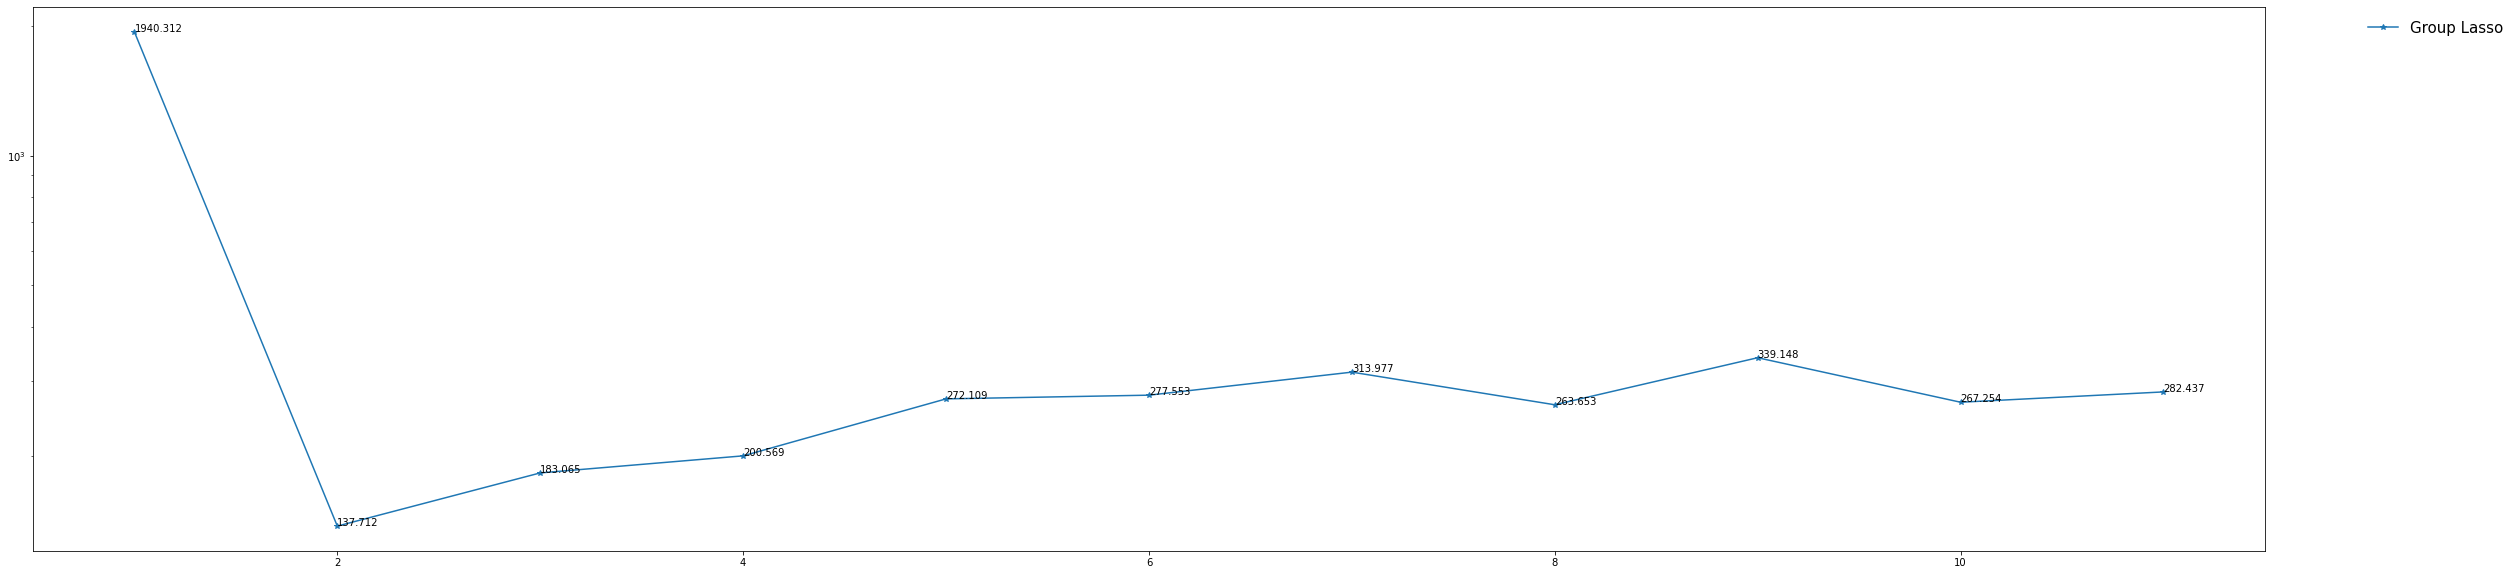

In [119]:
import matplotlib.pyplot as plt

loss_gl = losses[-1]
iters = np.arange(1, len(loss_gl)+1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iters, loss_gl, "-*", label = 'Group Lasso')
ax.legend(loc = 'upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor = (1.04, 1))
ax.set_yscale('log')
for i, j in zip(iters, loss_gl):
    ax.annotate("{:.3f}".format(j),xy=(i,j))

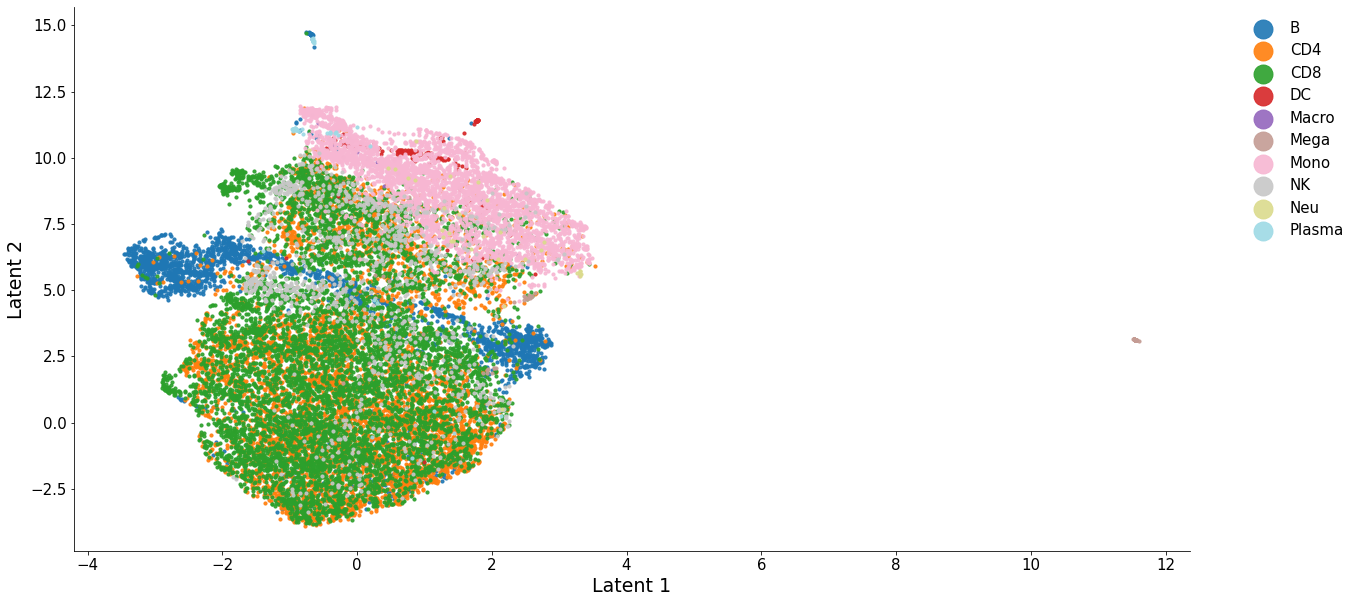

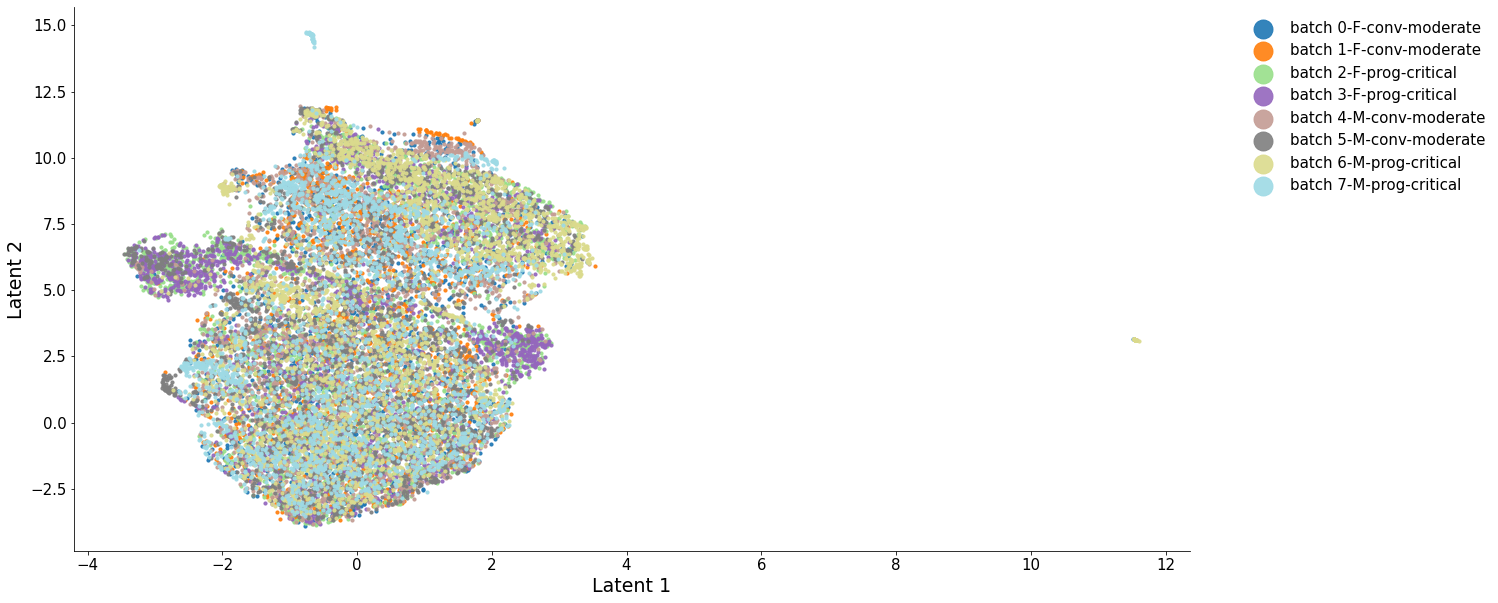

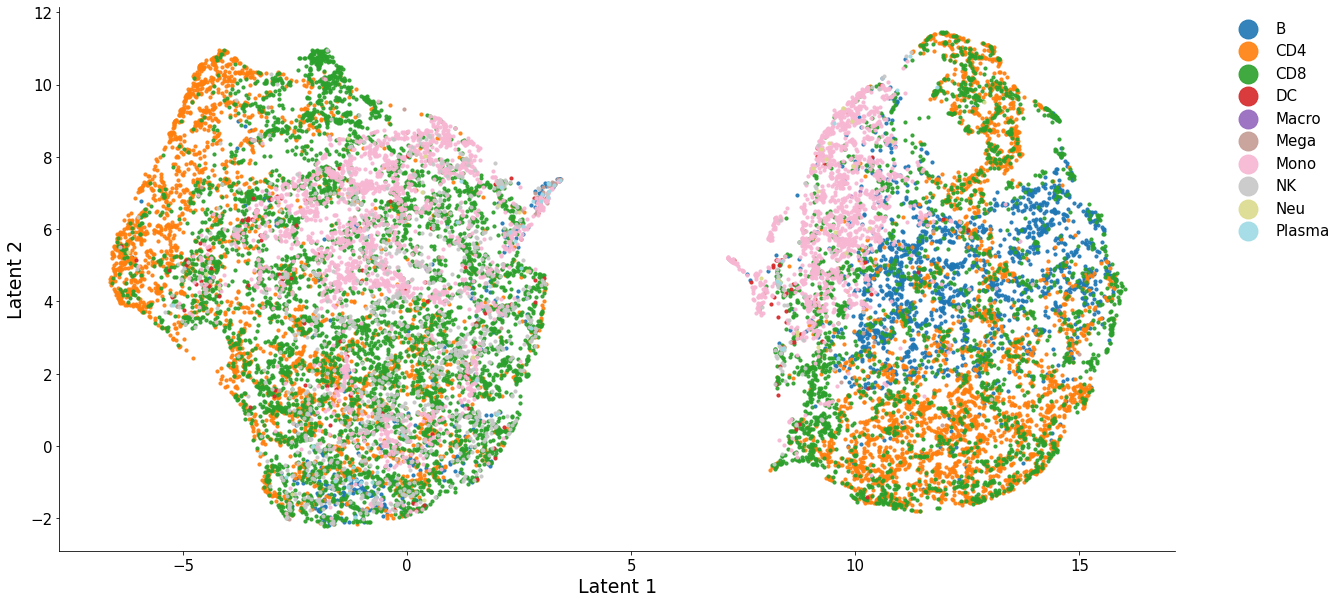

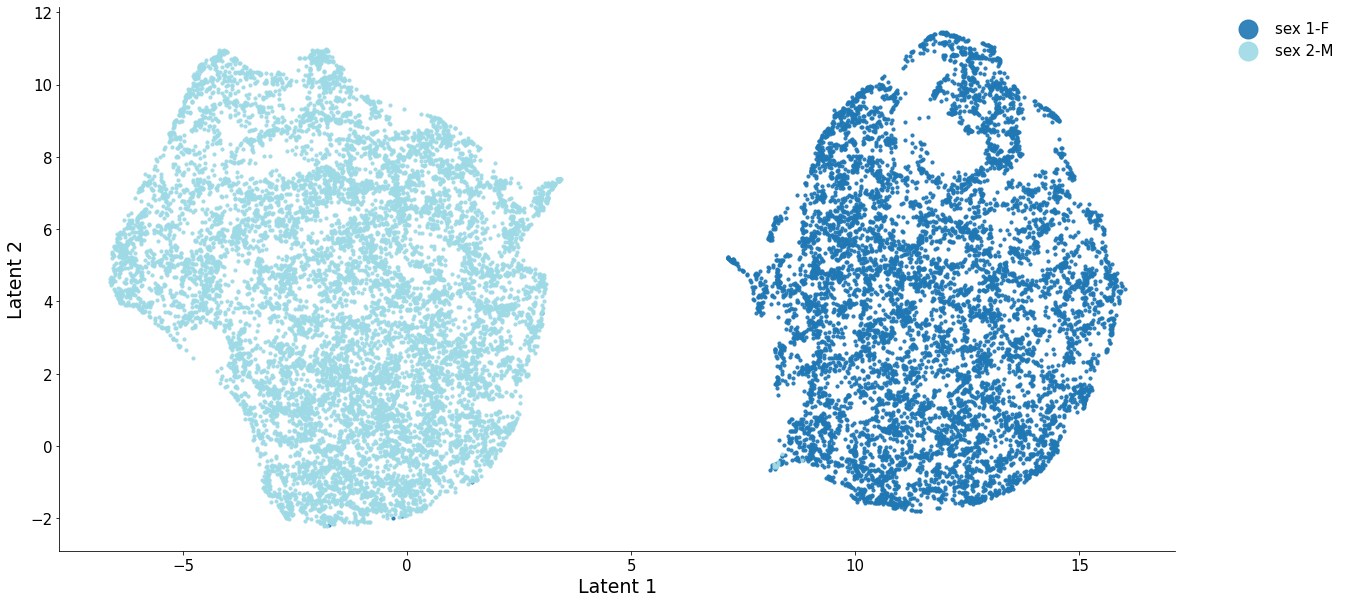

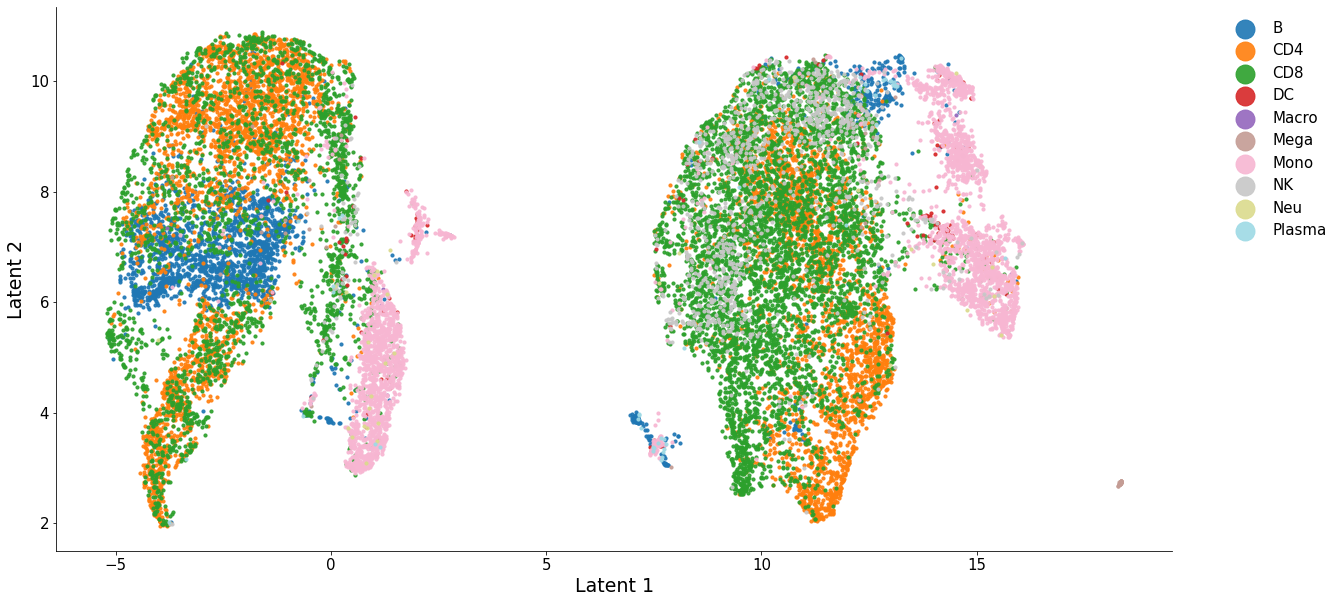

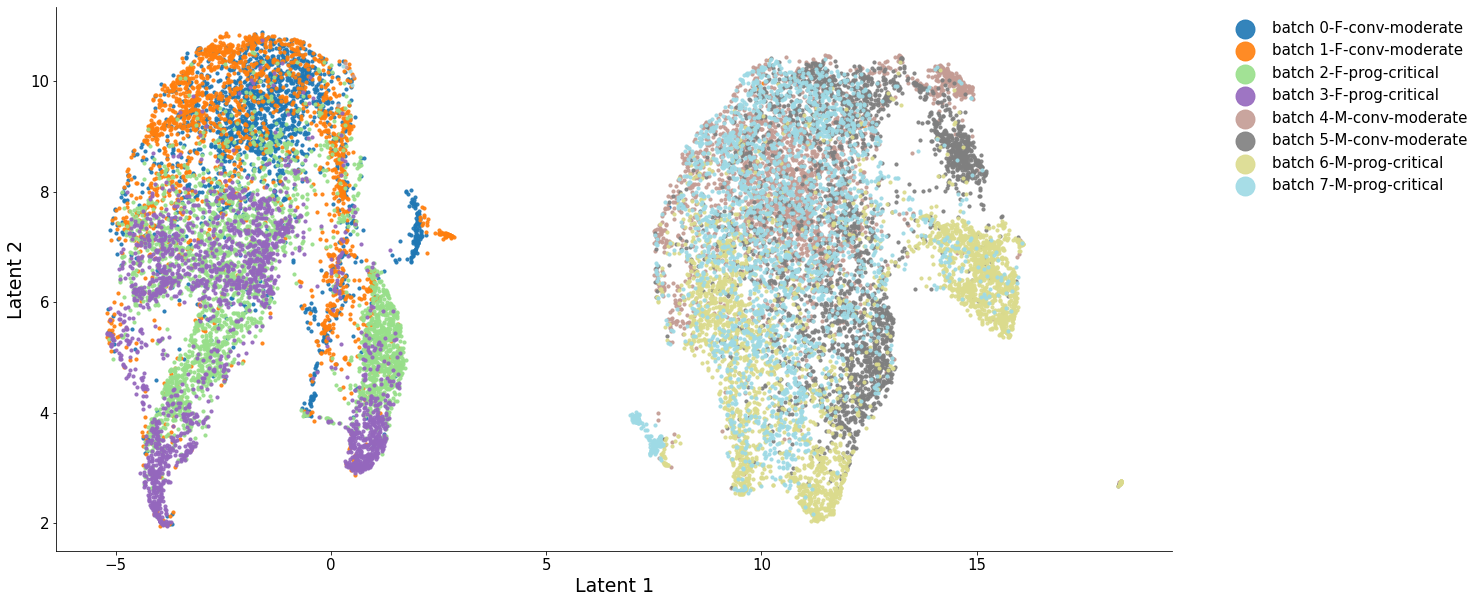

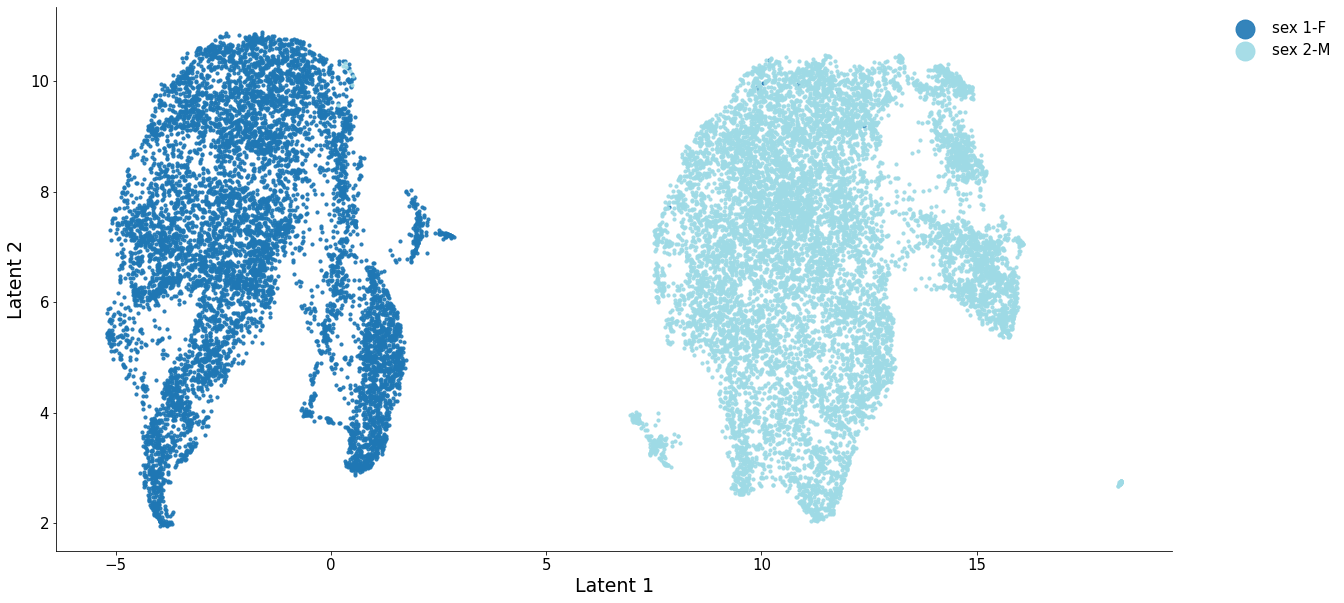

In [122]:
from umap import UMAP

z_cs = []
z_ts = []
zs = []
with torch.no_grad():
    for x in datasets:
        z_c = model1.Enc_c(x.counts_stand.to(model1.device))
        z_t = model1.Enc_t(x.counts_stand.to(model1.device))
        z_cs.append(z_c.cpu().detach().numpy())
        z_ts.append(z_t.cpu().detach().numpy())
        zs.append(torch.cat((z_c, z_t), dim = 1).cpu().detach().numpy())

    # UMAP
    umap_op = UMAP(min_dist = 0.1, random_state = 0)
    z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
    z_ts_umap = umap_op.fit_transform(np.concatenate(z_ts, axis = 0))
    zs_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

    z_ts_umaps = []
    z_cs_umaps = []
    zs_umaps = []
    for batch in range(n_batches):
        if batch == 0:
            start_pointer = 0
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])

        elif batch == (n_batches - 1):
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:,:])
            zs_umaps.append(zs_umap[start_pointer:,:])

        else:
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])
#     Ks = [20, 12]
    comment = r'sex_comb_mix_circle_{}_{}_{}_{}_'.format(m, gamma, lambs[-1], Ks)
#     comment = r'SupContr_{}'.format(lambs[-1])
#     result_dir = r'./covid_results/new/prog_with_control/'
    result_dir = r'./covid_results/sex/'
#     result_dir = None
    utils.plot_latent(zs = z_cs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"common_dims_celltypes.png") if result_dir else None , markerscale = 6)
    utils.plot_latent(zs = z_cs_umaps, annos = str_batches, mode = "joint", save = (result_dir + comment+"common_dims_batches.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"time_dims_celltypes.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_tp, mode = "joint", save = (result_dir + comment+"time_dims_timepoint.png".format()) if result_dir else None, markerscale = 6)
    
    utils.plot_latent(zs = zs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"all_dims_celltypes.png") if result_dir else None , markerscale = 6)
    utils.plot_latent(zs = zs_umaps, annos = str_batches, mode = "joint", save = (result_dir + comment+"all_dims_batches.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = zs_umaps, annos = str_tp, mode = "joint", save = (result_dir + comment+"all_dims_time.png".format()) if result_dir else None, markerscale = 6)    